In [3]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

There should be 404 training samples and 102 test samples, each with 13 numerical features

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [8]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [12]:
# Normalise the data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [13]:
from tensorflow import keras
from keras import layers

In [14]:
# build the model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # A linear layer
        # Because the last layer is purely linear, the model is free to learn to predict values in any range
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [33]:
# K-fold cross-validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], train_targets[(i+1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    all_mae_histories.append(history.history["mae"])

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [26]:
all_scores

[2.8188488483428955, 3.422212839126587, 3.839404821395874, 3.7698161602020264]

In [27]:
np.mean(all_scores)

3.4625706672668457

In [34]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [35]:
average_mae_history

[20.763075351715088,
 17.63191032409668,
 13.900779247283936,
 10.044911623001099,
 7.206756949424744,
 5.6323535442352295,
 4.6082154512405396,
 3.9706256985664368,
 3.5289801955223083,
 3.2806960940361023]

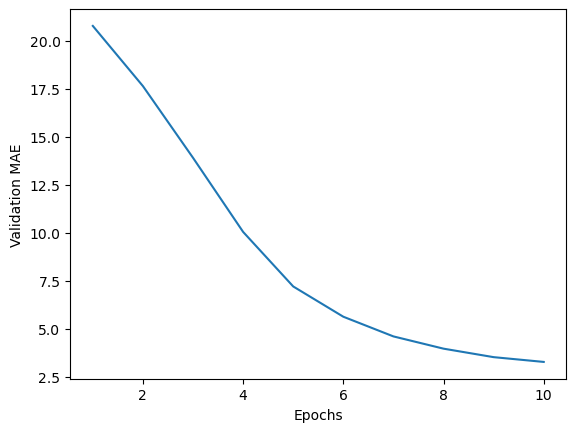

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [38]:
# Train the final model
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 5ms/step - loss: 13.5123 - mae: 2.3074


In [39]:
test_mae_score

2.307410955429077

In [40]:
# Generate predictions on new data
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 2ms/step


array([7.2867804], dtype=float32)